In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Label Encoding simple
from sklearn.preprocessing import LabelEncoder
# Now quick model
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## A. Load Data

In [2]:
# Load datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

## B. Initial Data Check

In [3]:
# Display shape
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (8523, 12)
Test shape: (5681, 11)


In [4]:
# Preview data
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## C. Missing Values

In [5]:
# Missing values
train.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [6]:
test.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

## D. Exploratory Data Analysis (EDA)

### Numerical Features

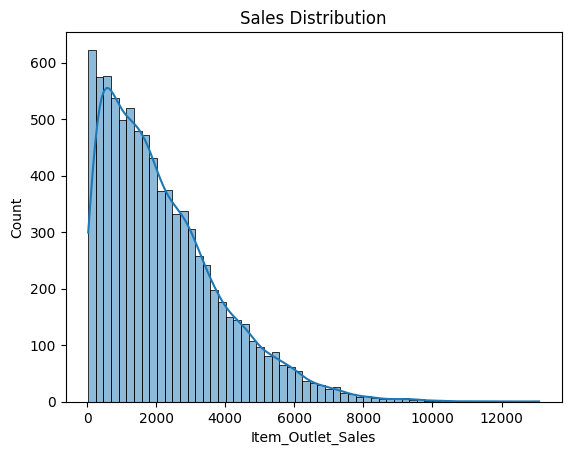

<Axes: xlabel='Outlet_Type', ylabel='Item_Outlet_Sales'>

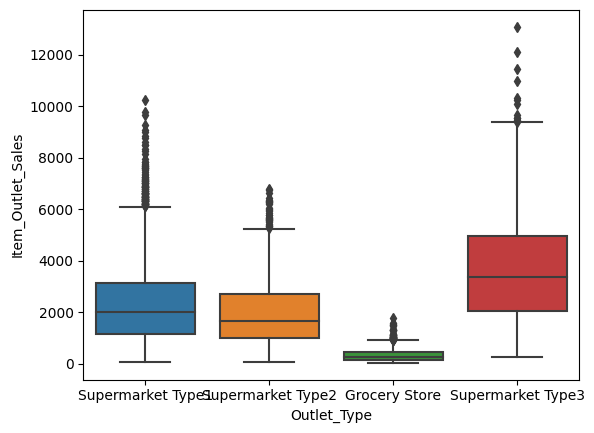

In [7]:
sns.histplot(train['Item_Outlet_Sales'], kde=True)
plt.title('Sales Distribution')
plt.show()

sns.boxplot(data=train, x='Outlet_Type', y='Item_Outlet_Sales')

### Categorical Features

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Low Fat'),
  Text(1, 0, 'Regular'),
  Text(2, 0, 'low fat'),
  Text(3, 0, 'LF'),
  Text(4, 0, 'reg')])

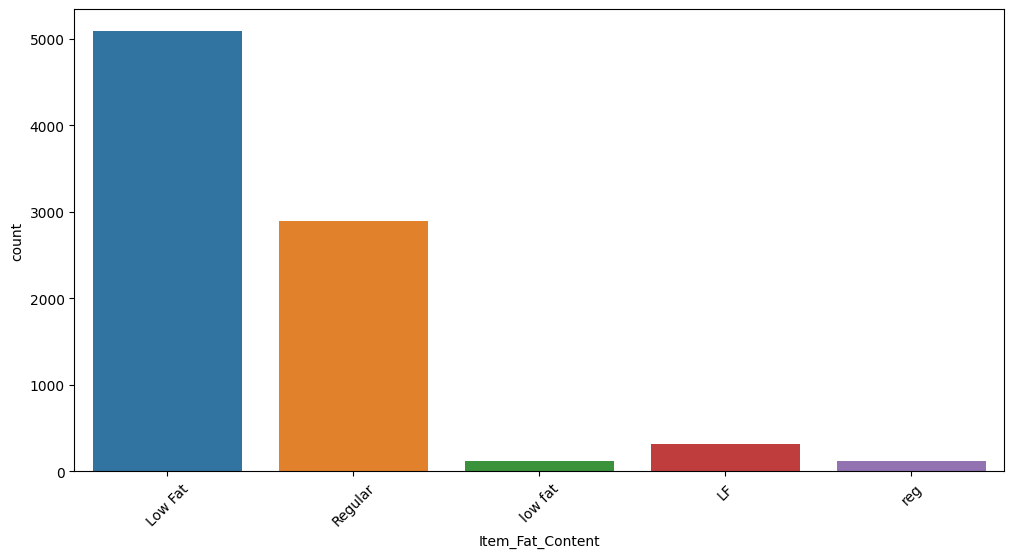

In [8]:
plt.figure(figsize=(12,6))
sns.countplot(x='Item_Fat_Content', data=train)
plt.xticks(rotation=45)

### Look at unique values in each categorical column:

In [9]:
for col in train.select_dtypes(include='object'):
    print(col, ":", train[col].unique())

Item_Identifier : ['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']
Item_Fat_Content : ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
Item_Type : ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Outlet_Identifier : ['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
Outlet_Size : ['Medium' nan 'High' 'Small']
Outlet_Location_Type : ['Tier 1' 'Tier 3' 'Tier 2']
Outlet_Type : ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


## E. Feature Engineering Summary

In [10]:
train['Outlet_Age'] = 2025 - train['Outlet_Establishment_Year']

## Phase 1: Quick-and-Dirty Model (Baseline)

In [11]:
# Quick simple filling
train['Item_Weight'].fillna(train['Item_Weight'].mean(), inplace=True)
test['Item_Weight'].fillna(test['Item_Weight'].mean(), inplace=True)

train['Outlet_Size'].fillna(train['Outlet_Size'].mode()[0], inplace=True)
test['Outlet_Size'].fillna(test['Outlet_Size'].mode()[0], inplace=True)

In [12]:
le = LabelEncoder()
for col in ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']:
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

In [13]:
X = train.drop(['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales'], axis=1)
y = train['Item_Outlet_Sales']

In [14]:
# Split into train and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [16]:
# Predict on validation set
rf_predictions = model.predict(X_val)

In [17]:
# Calculate RMSE
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_predictions))
print(f'Random Forest RMSE: {rf_rmse}')

Random Forest RMSE: 1087.9039901456304


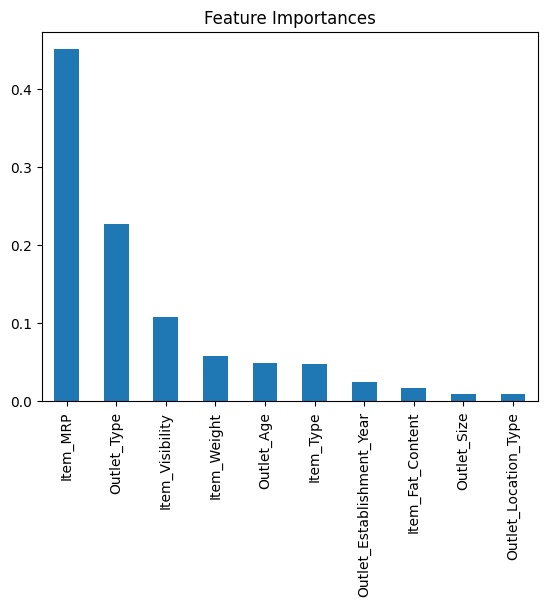

In [18]:
# Feature importance
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importances')
plt.show()

## Phase 2

In [19]:
# 1. Fix Fat Content
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace({0:'LF',1:'Regular',2:'reg', 3:'Low Fat', 4:'low fat'})
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace({0:'LF',1:'Regular',2:'reg', 3:'Low Fat', 4:'low fat'})

In [20]:
# 2. Replace zero visibility with mean visibility per item
train.loc[train['Item_Visibility'] == 0, 'Item_Visibility'] = train['Item_Visibility'].mean()
test.loc[test['Item_Visibility'] == 0, 'Item_Visibility'] = test['Item_Visibility'].mean()

In [21]:
# 3. Create Outlet Age
train['Outlet_Age'] = 2025 - train['Outlet_Establishment_Year']
test['Outlet_Age'] = 2025 - test['Outlet_Establishment_Year']

In [22]:
# 4. Create Item Visibility Mean Ratio
visibility_avg = train.groupby('Item_Identifier')['Item_Visibility'].mean()
train['Item_Visibility_MeanRatio'] = train.apply(lambda x: x['Item_Visibility']/visibility_avg[x['Item_Identifier']], axis=1)
test['Item_Visibility_MeanRatio'] = test.apply(lambda x: x['Item_Visibility']/visibility_avg.get(x['Item_Identifier'], 1), axis=1)

In [23]:
# 5. Create Broad Item Categories
def item_category(x):
    if x in [4, 15, 6, 10, 1, 5, 7, 8, 9, 11, 13, 16]: # Food-related encoded Item_Type
        return 'Food'
    elif x in [12, 14, 17]:
        return 'Non-Consumable'
    else:
        return 'Drinks'

train['Item_Category'] = train['Item_Type'].apply(item_category)
test['Item_Category'] = test['Item_Type'].apply(item_category)

In [24]:
# 6. Label Encode new features
for col in ['Item_Fat_Content', 'Item_Category']:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

In [25]:
# 7. Final Feature Set
drop_cols = ['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year', 'Item_Type']
X_train = train.drop(columns=drop_cols + ['Item_Outlet_Sales'])
y_train = train['Item_Outlet_Sales']
X_test = test.drop(columns=drop_cols)

In [26]:
# Split the train data into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [27]:
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_val[col] = le.transform(X_val[col])

In [28]:
# Train XGBoost
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [29]:
# Predict on the validation set
val_predictions = xgb.predict(X_val)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
print(f"RMSE: {rmse}")

RMSE: 1101.7962734584066


In [ ]:
# Predict on the test set
test_predictions = xgb.predict(X_test)

# Final Submission
submission = pd.DataFrame({
    'Item_Identifier': test['Item_Identifier'],
    'Outlet_Identifier': test['Outlet_Identifier'],
    'Item_Outlet_Sales': test_predictions
})

submission.to_csv('../submission/submission.csv', index=False)